# Code for fitting Astero RC data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 
import pandas as pd
import pystan

import os
import pickle

els = False

import sys

In [2]:
def read_data(els=False, data_file=''):
    
    if els and data_file == '':
        sfile = '../data/KepxDR2/elsxrcxyu18.csv'
    elif data_file != '':
        sfile = data_file
    else:
        sfile = '../data/KepxDR2/rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [3]:
df = read_data(els, data_file='rcxyu18.csv')
print('Size: '+str(len(df)))
df.head(2)

Size: 7497


,KICID,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,BC_GBP,BC_GRP,BC_J,BC_H,BC_K,ast_MKs,ast_MH,ast_MJ,ast_MG,ast_M_err
0,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,...,-0.740,0.388,1.206,1.638,1.766,-1.671046,-1.543046,-1.111046,0.343954,0.206767
1,1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,...,-0.754,0.409,1.252,1.706,1.840,-1.878376,-1.744376,-1.290376,0.205624,0.166498


In [4]:
if els:
    df = df[df.dnu <4.5] # Cut in Dnu
    sns.distplot(df.ast_MKs[df.elstage=='RC'],label='RC')
    sns.distplot(df.ast_MKs[df.elstage=='2CL'],label='2CL')
    sns.distplot(df.ast_MKs[df.elstage=='RGB'],label='RGB')
    sns.distplot(df.ast_MKs, label='Full')
    plt.legend(fontsize=15)
    plt.show()
    print('Targets: '+str(len(df)))

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


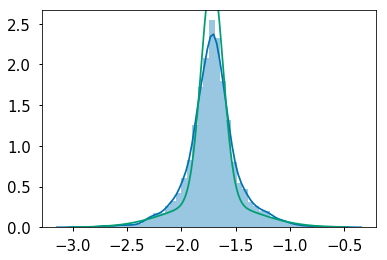

-1.7155484516776585


In [5]:
'''Step one is figuring out the different distributions we want'''
df.head(2)
Ks = df.ast_MKs.values
x = np.linspace(Ks.min(),Ks.max(),1000)

rQ = 0.7
rmu = np.median(Ks)
rsigma = .1
rsigo = 4.*rsigma

rfg = normal(x, rmu, rsigma)
rbg = normal(x, rmu, rsigo)
pp = rQ*rfg + (1-rQ)*rbg

sns.distplot(Ks, label='Observed')
plt.plot(x,pp, label='Likelihood')
plt.show()

print(np.median(Ks))

## Stan model for asteroseismic values

In [6]:
overwrite = True
asterostan = '''
data {
    int<lower = 0> N;
    real Mobs[N];
    real Munc[N];
}
parameters {
    //Hyperparameters
    real mu;
    real <lower=0.> sigma;
    real <lower=0.5,upper=1.> Q;
    real <lower=1.> sigo;

    //Latent Parameters
    real Mtrue_std[N];
}
transformed parameters{
    real Mtrue[N];
    
    for (n in 1:N){
        Mtrue[n] = mu + sigma * Mtrue_std[n];
    }
}
model {
    mu ~ normal(-1.7, 1.0);  //p(theta)
    sigma ~ normal(0.0, 1.0); //''
    sigo ~ normal(3.0, 2.0);  //''
    Q ~ normal(1., 0.1);    //''  
    
    Mobs ~ normal(Mtrue, Munc); //p(D | theta, alpha)
    
    //p(alpha | theta)
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(Mtrue_std[n] | 0., 1.),
                    normal_lpdf(Mtrue_std[n] | 0., sigo));
}
'''
model_path = 'asterostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL asterostan_d9049c130196e572e3a935a377cfeeaa NOW.


Updating Stan model


In [ ]:
sel = df
Mobs = sel.ast_MKs
Munc = sel.ast_M_err.values
m = sel.Kmag.values
dat = {'N': len(sel),
      'Mobs': Mobs,
      'Munc' : Munc}

init = {'mu': rmu,
       'sigma': rsigma,
        'Q': rQ,
       'sigo': rsigo/rsigma}
fit = sm.sampling(data=dat, warmup=10000, iter=12000, chains=4, init=[init,init,init,init])

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [ ]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']])
corner.corner(chain.T,labels=['mu','sigma','Q','sigo'],
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [ ]:
fit.plot()
plt.show()

In [ ]:
print(fit)

In [ ]:
s = fit.summary()
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

In [ ]:
sns.distplot(fit['Mtrue_std'].mean(axis=0), )